**今回の実習内容**
 * 回転行列による三次元構造の回転
 * 実習課題

In [1]:
import sys, math, os
import numpy as np
import time
import copy
import tifffile as tiff
import mrcfile as mrc
from matplotlib import pyplot as plt

# OpenCV
import cv2

In [2]:
# テストデータの読み込み
fn_map = 'data/course3_3dmap.mrc'

# dataに3dマップを読み出し
data = mrc.read(fn_map)

print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(102, 102, 102)


**投影像を作ってみる**
 * z軸への投影を考える
 * 単純にz成分を足し合わせればいい

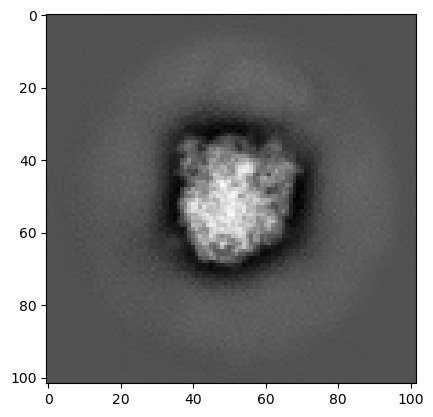

In [3]:
proj = data.sum(axis=0)   # 0=z; 1=y; 2=x

plt.imshow(proj, cmap='Greys_r')

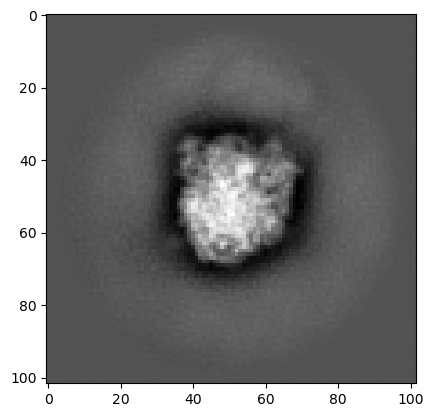

In [4]:
# 実際にrelionで作った投影像と比較する

fn_ref = './data/course3_proj_0_0_0.mrc'

refdata = mrc.read(fn_ref)

plt.imshow(refdata, cmap='Greys_r')

* 三次元構造を回転させて投影像を計算してみる
* そのためにまずは必要な関数を定義する

In [5]:
# 線形補間の関数を定義しておく

def linterp(frac, low, high):
    return low + (high - low) * frac

In [6]:
# 回転行列から回転後の投影像を計算する
# 引数
# vol: 3D ndarray (三次元構造)
# image: 2D ndarray (二次元投影像)
# a3d: 2D ndarray (回転行列)

# 返り値はないがimageが更新される

def project(vol, image, a3d):

    debug = False

    # inverse the input rotation matrix a3d (a3d^-1 = a3d^T)
    # 余裕のある人はなぜ逆行列にするか考えてみてください
    ainv = a3d.T

    if debug:
        print('a3d_inv:')
        print(ainv)
    
    # 0 = z, 1 = y, 2 = x
    boxsize = vol.shape

    # check x-y slice of vol and image have the same shape
    if (boxsize[1] != image.shape[0] or boxsize[2] != image.shape[1]):
        print('Error: output image has different shape from that of input volume')
        sys.exit()

    # output 2d image (image_out) will be always initialised
    image[:] = 0

    if debug:
        print('boxsize: ', boxsize)

    # boxの内接球の領域だけを計算する
    # そのための最大半径を定義
    _radius = np.zeros(3, dtype=int)
    for i in range(3):
        _radius[i] = math.floor(boxsize[i] / 2) - 1

    if debug:
        print('_radius: ', _radius)

    _rmax_out: int = _radius.min()
    _rmax_out_2: int = _rmax_out * _rmax_out;

    if debug:
        print('_rmax_out: ', _rmax_out)
        print('_rmax_out_2: ', _rmax_out_2)
    
    # loop for z-axis component
    for k in range(boxsize[0]):

        z: int = 0
        
        # boxsizeが奇数かどうかで場合分け
        if boxsize[0] % 2 == 0:
            z = k - _radius[0] if k <= _radius[0] else k - (_radius[0] + 1)
        else:
            z = k - (_radius[0] + 1)

        z2 = z * z

        if z2 > _rmax_out_2:
            continue
        
        # ymax depends on current z
        ymax = math.floor(math.sqrt(_rmax_out_2 - z2))

        # loop for y-axis component
        for j in range(boxsize[1]):

            y: int = 0
            
            # boxsizeが奇数かどうかで場合分け
            if boxsize[1] % 2 == 0:
                y = j - _radius[1] if j <= _radius[1] else j - (_radius[1] + 1)
            else:
                y = j - (_radius[1] + 1)

            y2 = y * y

            if (y2 > ymax * ymax):
                continue
        
            # xmax depends on current z and y
            xmax = math.floor(math.sqrt(_rmax_out_2 - z2 - y2)) 

            # loop for x-axis component
            for i in range(boxsize[2]):

                x: int = 0
            
                # boxsizeが奇数かどうかで場合分け
                if boxsize[2] % 2 == 0:
                    x = i - _radius[2] if i <= _radius[2] else i - (_radius[2] + 1)
                else:
                    x = i - (_radius[2] + 1)

                if x * x > xmax * xmax:
                    continue

                #  Get logical coordinates in the 3D map
                xp = ainv[0,0] * x + ainv[0,1] * y + ainv[0,2] * z
                yp = ainv[1,0] * x + ainv[1,1] * y + ainv[1,2] * z
                zp = ainv[2,0] * x + ainv[2,1] * y + ainv[2,2] * z

                # guarantee logical coordinates are always within rmax_out shell
                if (xp * xp + yp * yp + zp * zp) > _rmax_out_2:
                    continue

                # define nearest gridding coordinates
                x0 = math.floor(xp)
                fx = xp - x0
                if boxsize[0] % 2 == 0:
                    x0 += _radius[0]
                else:
                    x0 += _radius[0] + 1                    
                x1 = x0 + 1

                y0 = math.floor(yp)
                fy = yp - y0
                if boxsize[1] % 2 == 0:
                    y0 += _radius[1]
                else:
                    y0 += _radius[1] + 1
                y1 = y0 + 1

                z0 = math.floor(zp)
                fz = zp - z0
                if boxsize[2] % 2 == 0:
                    z0 += _radius[2]
                else:
                    z0 += _radius[2] + 1
                z1 = z0 + 1

                if x0 < 0 or x0+1 >= boxsize[0] or y0 < 0 or y0+1 >= boxsize[1] or z0 < 0 or z0+1 >= boxsize[2]:
                    continue

                v000 = vol[z0,y0,x0]
                v001 = vol[z0,y0,x1]
                v010 = vol[z0,y1,x0]
                v011 = vol[z0,y1,x1]
                v100 = vol[z1,y0,x0]
                v101 = vol[z1,y0,x1]
                v110 = vol[z1,y1,x0]
                v111 = vol[z1,y1,x1]

                # set the interpolated value in the 3D output array
                # x-axis
                vx00 = linterp(fx, v000, v001)
                vx01 = linterp(fx, v100, v101)
                vx10 = linterp(fx, v010, v011)
                vx11 = linterp(fx, v110, v111)

                # y-axis
                vxy0 = linterp(fy, vx00, vx10)
                vxy1 = linterp(fy, vx01, vx11)

                # z-axis (and final value)
                image[j,i] += linterp(fz, vxy0, vxy1)
    
    return

**投影像の計算**
 * 定義した関数を使って投影像を計算する
 * まず回転行列を計算してその後に関数を呼ぶ
 * この例では回転行列を直接定義する

rotation matrix:
[[-0.12682648  0.9267767  -0.35355339]
 [-0.78033009  0.12682648  0.61237244]
 [ 0.61237244  0.35355339  0.70710678]]
shape of projection image:
(102, 102)


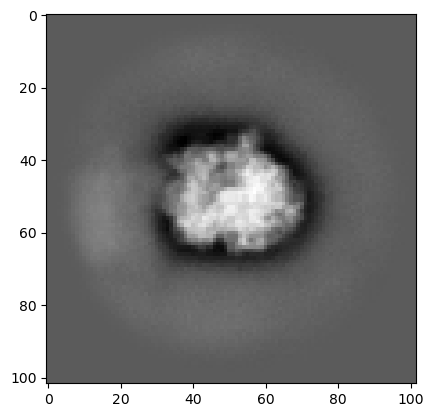

In [7]:
# まず回転行列を定義
# rot = 30, tilt = 45, psi = 60 に相当 (度数単位)

rotation = np.zeros((3,3))

rotation[0, 0] = -0.12682648
rotation[0, 1] =  0.9267767
rotation[0, 2] = -0.35355339
rotation[1, 0] = -0.78033009
rotation[1, 1] =  0.12682648
rotation[1, 2] =  0.61237244
rotation[2, 0] =  0.61237244
rotation[2, 1] =  0.35355339
rotation[2, 2] =  0.70710678

print('rotation matrix:')
print(rotation)

# 三次元構造のx-y成分と同じサイズの投影像配列を用意
proj = np.zeros(data.shape[1:])

print('shape of projection image:')
print(proj.shape)

# 上で定義した関数を使って投影像を計算
project(data, proj, rotation)

plt.imshow(proj, cmap='Greys_r')

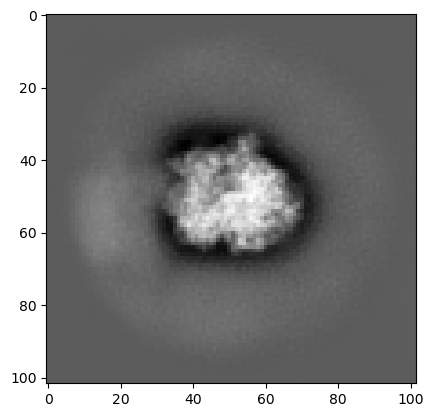

In [8]:
# relionで作った投影像と比較

fn_ref = './data/course3_proj_30_45_60.mrc'

refdata = mrc.read(fn_ref)

plt.imshow(refdata, cmap='Greys_r')

**実習課題**
 * 次の配向の投影像を作りましょう: rot = 73, tilt = 129, psi = 38
 * まずオイラー角から回転行列を計算する関数を作りましょう
 * 具体的な計算方法は講義資料を見てください(commonにアップロードしてあります)
 * 作った関数が正しければ、rot = 30, tilt = 45, psi = 60を指定すると例で使った回転行列が出てきます
 * 関数"project"を呼ぶときには、投影像用の配列サイズを事前に決めてから呼ばないとエラーになります
 * 上の例ではprojを定義するときに一緒にサイズも指定しています

In [ ]:
# relionで計算した rot = 73, tilt = 129, psi = 38 の投影像
fn_correct = './data/course3_proj_73_129_38.mrc'

correct = mrc.read(fn_correct)

plt.imshow(correct, cmap='Greys_r')

**発展課題**
 * プロジェクションマッチングをやってみましょう
 * 以下に示す投影像の配向を推定してください
 * 簡単のためにrot, tiltは10度刻み、psiは変えていません(=0)
 * ただし投影後に少しだけ並進させています(x, yともに5ピクセル以内)

In [ ]:
plt.imshow(mrc.read('./data/course3_proj_unknown.mrc'), vmin = 0.0, cmap='Greys_r')